How to install module:


- https://pypi.org/project/seissolxdmf/
- !pip install seissolxdmf

In [54]:
# download from https://pypi.org/project/seissolxdmf/
import seissolxdmf 

import pyproj

import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib

import numpy as np

from cmcrameri import cm

from mpl_toolkits.basemap import Basemap, maskoceans
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from netCDF4 import Dataset

import pandas as pd

In [55]:
plt.rcParams["font.family"] = "sans-serif"
ps = 18
plt.rcParams.update({"font.size": ps})
plt.rcParams["font.family"] = "sans"
matplotlib.rc("xtick", labelsize=ps)
matplotlib.rc("ytick", labelsize=ps)

In [56]:
#transformer = pyproj.Transformer.from_crs("utm27", "epsg:4326", always_xy=True)
transformer = pyproj.Transformer.from_crs("+proj=tmerc +datum=WGS84 +k=0.9996 +lon_0=26.25 +lat_0=37.75", "epsg:4326", always_xy=True)

In [57]:
def plot_ssha(xdmfFilename,timestep):
    x1, x2, y1, y2 = 25.4, 27.5, 37.6, 38.3 #Samos
    m = Basemap(epsg=4326, resolution="c", llcrnrlon=x1, urcrnrlon=x2, llcrnrlat=y1, urcrnrlat=y2)#4326
    bathy = "/import/freenas-m-05-seissol/kutschera/HIWI/meshing/CAD_EasternAegeanSea_new/GEBCO_11_Oct_2022_520fc88fe900/gebco_2022_n40.0_s36.0_w23.0_e29.0.nc"
    fh = Dataset(bathy, mode="r")
    y = fh.variables["lat"][:]
    x = fh.variables["lon"][:]
    z = fh.variables["elevation"][:, :]
    fh.close()
    idx = np.where((x > x1) & (x < x2))[0]
    idy = np.where((y > y1) & (y < y2))[0]
    x = x[idx]
    y = y[idy]
    z = z[idy, :]
    z = z[:, idx]
    lon, lat = np.meshgrid(x, y)
    X, Y = m(lon, lat)
    # Coast line
    plt.contour(X, Y, z, levels=[0], colors="k", linewidths=0.8)

    sx = seissolxdmf.seissolxdmf(xdmfFilename) # initiate class
    xyz = sx.ReadGeometry() # load geometry array as a numpy array of shape
    connect = sx.ReadConnect() # load connectivity array as a numpy array of shape
    U = sx.ReadData("u3", timestep)    
    XYZcenters0 = (xyz[connect[:, 0], :] + xyz[connect[:, 1], :] + xyz[connect[:, 2], :]) / 3.0
    Zcenters0 = abs(XYZcenters0[:, 2])
    U = U[Zcenters0 < 0.001]
    print(min(U), max(U))
    connect = connect[Zcenters0 < 0.001]
    
    lon, lat = transformer.transform(xyz[:,0], xyz[:,1])
    x, y = m(lon,lat)
    plt.tripcolor(x, y, connect, facecolors=U, cmap=cm.cork, rasterized=True)
    plt.xlim(x1,x2)
    #plt.xticks(np.arange(x1,x2, step=0.5))
    x_ticks = np.arange(25.5,28.0, step=0.5)
    sub_x = np.repeat("° E", len(x_ticks))
    plt.xticks(ticks=x_ticks, labels = np.char.add(x_ticks.astype(str), sub_x))
    plt.ylim(y1,y2)
    y_ticks = np.arange(37.6, 38.2, step=0.2)
    sub_y = np.repeat("° N", len(y_ticks))
    plt.yticks(ticks=y_ticks, labels = np.char.add(np.round(y_ticks, 1).astype(str), sub_y))
    #plt.title("t = {} s".format(timestep))
    plt.title("t = {} min".format(int(timestep/60)))
    plt.clim(-0.8, 0.8)
    
    plt.text(27.0, 38.15, "ssha (m)", horizontalalignment='center', verticalalignment='center',
             fontsize=ps, rotation="horizontal")
    #cbaxes = inset_axes(ax1, width=0.15, height="50%", loc=4, borderpad=3)
    cbaxes = inset_axes(ax1, width="45.2%", height="5%", loc="upper right")
    cbar = plt.colorbar(orientation="horizontal", cax=cbaxes, ticks=[-0.8,0.0,0.8], extend="both")
    cbar.ax.tick_params(which="major", labelsize=ps, length=10, width=2, direction="inout")
    cbar.ax.tick_params(which="minor", length=6, width=1.0)
    cbar.ax.minorticks_on()

-1.1685157161520532 0.9267461555623695


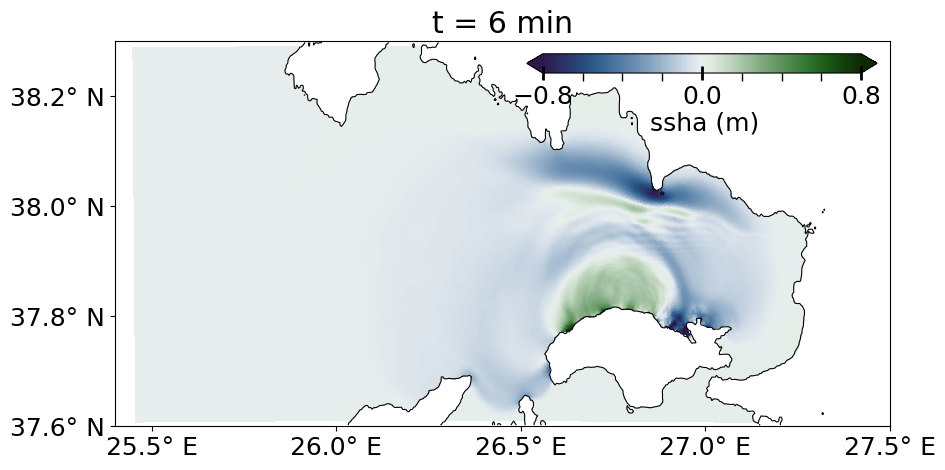

In [58]:
model = "Fra" 
xdmfFilename = '/import/freenas-m-05-seissol/kutschera/MAthesis_fkutschera/simulations/Samos_final_{}_v1/{}_v1_WL-surface.xdmf'.format(model,model)
fig = plt.figure()
fig.set_size_inches(10, 5)
ax1 = plt.gca()
time = 360 #s
plot_ssha(xdmfFilename,time)
#fig.savefig("output/ssha_fully_{}_{}s.png".format(model, time), dpi=300)

In [59]:
from clawpack.geoclaw import fgout_tools

In [68]:
def plot_ssha_geoclaw(framenr):
    x1, x2, y1, y2 = 25.4, 27.5, 37.6, 38.3 #Samos
    fgno = 1
    outdir = '_output'
    output_format = 'binary'
    
    # Instantiate object for reading fgout frames:
    fgout_grid = fgout_tools.FGoutGrid(fgno, outdir, output_format)
    
    # Plot one frame of fgout data 
    fgframe = framenr # frame -1 = minutes
    fgout = fgout_grid.read_frame(fgframe)
    
    eta_water = np.where(fgout.h > 0, fgout.eta, np.nan)
    img = plt.imshow(np.flipud(eta_water.T), extent=fgout.extent_edges, cmap=cm.cork, aspect='auto')#aspect=9.45/4.7)
    plt.clim(-0.8, 0.8)
    plt.contour(fgout.X,fgout.Y,fgout.B,[0.],colors='k', linewidths=0.8)  # coastline
    plt.title("t = {} min".format(int(fgout.t/60)))
    
    # ticks
    plt.xlim(x1,x2)
    x_ticks = np.arange(25.5,28.0, step=0.5)
    sub_x = np.repeat("° E", len(x_ticks))
    plt.xticks(ticks=x_ticks, labels = np.char.add(x_ticks.astype(str), sub_x))
    plt.ylim(y1,y2)
    y_ticks = np.arange(37.6, 38.2, step=0.2)
    sub_y = np.repeat("° N", len(y_ticks))
    plt.yticks(ticks=y_ticks, labels = np.char.add(np.round(y_ticks, 1).astype(str), sub_y))
    
    # colorbar
    cbaxes = inset_axes(ax1, width="45.2%", height="5%", loc="upper right")
    cbar = plt.colorbar(img, orientation="horizontal", cax=cbaxes, ticks=[-0.8,0.0,0.8], extend="both")
    cbar.ax.tick_params(which="major", labelsize=ps, length=10, width=2, direction="inout")
    cbar.ax.tick_params(which="minor", length=6, width=1.0)
    cbar.ax.minorticks_on()

    Reading  Frame 7 at t = 360  from outdir = /import/freenas-m-05-seissol/kutschera/MAthesis_fkutschera/GeoClaw/GeoClaw_Samos_Fra_v3/_output
    Setting grid attributes based on Frame 7:
      Grid edges:  [25.0, 27.5, 37.0, 39.0]
      with 1200 cells in x and 1500 cells in y


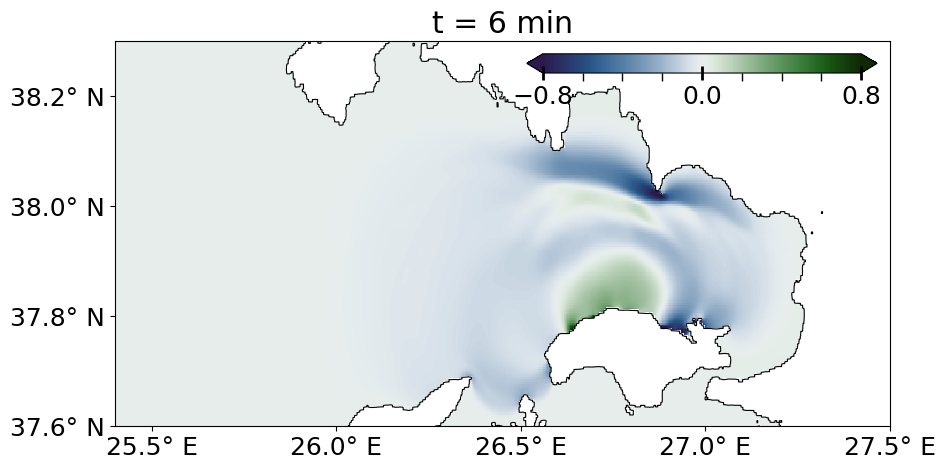

In [70]:
framenr = 7
my_dpi = 100
#plt.figure(figsize=(945/my_dpi, 470/my_dpi), dpi=my_dpi)
fig = plt.figure()
fig.set_size_inches(10, 5)
ax1 = plt.gca()
plot_ssha_geoclaw(framenr)